# Graded Assignment 2 – Modelling and Prediction <br>


Dataset of reviews for cars in ``car-reviews.csv`` <br>
Each review is labelled with either ‘Pos’ or ‘Neg’ to indicate
whether the review has been assessed as positive or negative in the sentiment it expresses. There are 1,382 reviews in the CSV file in total, with an equal representation of both positive
and negative classes (i.e. 691 reviews each).

### Task 1 (50%): Baseline solution - Naïve Bayes classifier

Parsing the file ``car-reviews.csv``

In [1]:
import pandas as pd
df = pd.read_csv('car-reviews.csv')
df.head()
df.describe()

,Sentiment,Review
count,1382,1382
unique,2,1382
top,Pos,It is a 92 got it used about a year after it...
freq,691,1


Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. <br>
Note that, the split is done randomly, since in this way we will help avoiding imbalanced datasets.

In [2]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# split the x and y data
x = np.asarray(df['Review'])
y = np.asarray(df['Sentiment'])
# split data into 80% train and 20% test
# note that "stratify=y" will split randomly while keep the proportion of y values through the training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)
# reshape so then can be concatenated to reform the dataframe

x_train = x_train.reshape(len(x_train), 1)
x_test = x_test.reshape(len(x_test), 1)
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
# arrays of training data and test data choosen randomly
arr_train = np.concatenate((y_train, x_train), axis=1)
arr_test = np.concatenate((y_test, x_test), axis=1)
# reconstruct the dataframe, now there are two dataframes, one for training and one for testing
df_train = pd.DataFrame(arr_train, columns=["Sentiment", "Review"])
df_test = pd.DataFrame(arr_test, columns=["Sentiment", "Review"])

Now, a bit of exploration of the datasets

In [3]:
df_train.head()

,Sentiment,Review
0,Neg,A LITTLE BIT ABOUT ME FIRST I have read man...
1,Neg,Driving a Ford Focus Rent a car while mine is...
2,Neg,We used to drive down the road and be jealous...
3,Neg,I always wanted a truck especially after own...
4,Pos,Captured by the styling I have to admit we...


In [4]:
df_train.describe()

,Sentiment,Review
count,1105,1105
unique,2,1105
top,Pos,It is a 92 got it used about a year after it...
freq,553,1


In [5]:
df_test.head()

,Sentiment,Review
0,Pos,I have a 1999 Wedgewood Blue ext cab 4 door ...
1,Pos,The Mustang coupe in premium trim offers a lo...
2,Neg,I currently own an Aspire and there are some ...
3,Neg,I purchased a 1995 Ford Contour in August 19...
4,Neg,I bought a 1990 ford probe gl in 1998 i paye...


In [6]:
df_test.describe()

,Sentiment,Review
count,277,277
unique,2,277
top,Neg,I dont even know where to begin This car wh...
freq,139,1


In [7]:
# checking if the train and test datasets are imbalanced
df_train_neg_review = df_train[df_train["Sentiment"]=='Neg']  
df_train_pos_review = df_train[df_train["Sentiment"]=='Pos']
print("number of samples in training dataset resulting in Negative Sentiment = ", df_train_neg_review.shape[0]) 
print("number of samples in training dataset resulting in Positive Sentiment = ", df_train_pos_review.shape[0])
print()

df_test_neg_review = df_test[df_test["Sentiment"]=='Neg']  
df_test_pos_review = df_test[df_test["Sentiment"]=='Pos']
print("number of samples in testing dataset resulting in Negative Sentiment = ", df_test_neg_review.shape[0]) 
print("number of samples in testing dataset resulting in Positive Sentiment = ", df_test_pos_review.shape[0])

number of samples in training dataset resulting in Negative Sentiment =  552
number of samples in training dataset resulting in Positive Sentiment =  553

number of samples in testing dataset resulting in Negative Sentiment =  139
number of samples in testing dataset resulting in Positive Sentiment =  138


From this quick analysis we can deduce that:
- the total dataset has been correctly splitted into 80% training and 20% testing data
- training and testing datasets are both balanced, so no need to apply special techniques to deal with imbalanced data!

Preprocessing
- Redundant token removal. Identifying and excluding all punctuation and common
words that are not likely to affect sentiment.
- Redundant formatting removal. Ensuring that remaining words are not case-sensitive
i.e. the classifier should not distinguish upper/lower case characters.

In [8]:
import numpy as np
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import OrdinalEncoder
from nltk.tokenize import word_tokenize

class PreprocessVectorization:
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.data = 0
        self.target = 0
        self.clean_stopwords_arr = 0
        self.cleanpunct_arr = 0
        self.lowercase_arr = 0
        self.stemmed_arr = 0
        self.unstemmed = 0
        self.stemmed = 0
        self.wordset_arr = 0
        self.word_to_idx = 0
        self.idx_to_word = 0
        self.bow_arr = 0
        self.target_encode = 0
    
    def set_data(self, target, data):
        """Collect the data in input"""
        self.target = target
        self.data = data
        
        
    # function to identify the stopw words within the sample, delete them and returning the cleaned sentence
    def clean_stopwords(self):
        """
        For feature reduction, since they will not add any value to the classification,
        deleting stop-words like and, or, etc.
        """
        in_arr = self.data
        self.clean_stopwords_arr=[]
        for sentence in in_arr:
            tmp_list=[]
            for word in sentence.split():
                if word.lower() not in self.stopwords:
                    tmp_list.append(word)
            self.clean_stopwords_arr.append(' '.join(tmp_list))
            
    def clean_punctuation(self):
        """
        For feature reduction, since they will not add any value to the classification,
        removing special characters/punctuations like !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~    
        """
        # first, split into words based on spacing
        in_arr = self.clean_stopwords_arr
        splitted_arr = np.empty(shape=(len(in_arr), 1), dtype=object)
        for row in range(len(in_arr)):
            splitted_arr[row] = np.char.split(in_arr[row])
        # remove special characters/punctuations
        in_arr = np.copy(splitted_arr)
        table = str.maketrans('', '', string.punctuation)
        self.cleanpunct_arr = np.empty(shape=(len(in_arr), 1), dtype=object)
        in_arr = np.reshape(in_arr, (len(in_arr), 1))
        for row in range(len(in_arr)):
            self.cleanpunct_arr[row, 0] = [w.translate(table) for w in in_arr[row][0][:]]
    
    def lower_case(self):
        """
        For feature reduction, since they will not add any value to the classification,
        words are converted to lower character.
        """
        # taking care of the case-sensitive words
        in_arr = self.cleanpunct_arr
        self.lowercase_arr = np.empty(shape=(len(in_arr), 1), dtype=object)
        for row in range(len(in_arr)):
            self.lowercase_arr[row, 0] = [w.lower() for w in in_arr[row][0][:]]
    
    def stemming(self):
        """
        For feature reduction, reducing the words to their stem or root only.
        e.g. before stemming:
        'complete', 'completely', 'completly', 'completed', 'completion', 'completing', 'completes'
        after stemming are reduced to only:
        'complet'
        """
        snow_stemmer = SnowballStemmer(language='english')
        in_arr = self.lowercase_arr
        temp_stemmed_arr=[]
        for row in range(len(in_arr)):
            stem_words = []  
            for word in in_arr[row][0][:]:
                val = snow_stemmer.stem(word)
                stem_words.append(val)
            temp_stemmed_arr.append(' '.join(stem_words))
        
        # the column 'Review' now including words filtered by their stems
        self.stemmed_arr = np.empty(shape=(len(temp_stemmed_arr), 1), dtype=object)
        for row in range(len(temp_stemmed_arr)):
            self.stemmed_arr[row] = np.char.split(temp_stemmed_arr[row])  
 

    def union_calc(self, in_arr):
        """
        Recursive method to find unique words by checking them in couples
        """
        if len(in_arr) == 1:
            return in_arr[0][0]
        else:
            return np.union1d( in_arr[0][0], self.union_calc(in_arr[1:]) )  
        
    
    def wordset_calc(self):
        """
        Receiving in input the array (num samples x 1) of sentences
        Returning as output:
        > the array containing the group of unique words which have been found in the entire dataset
        > the array to convert word_set_arr from word into index
        > the array to convert word_set_arr from index into word
        """

        in_arr = self.stemmed_arr
            
        self.wordset_arr = self.union_calc(in_arr)        
        self.word_to_idx = {}
        self.idx_to_word = {}
        for idx, word in enumerate(self.wordset_arr):
            # Set the mapping indexes.
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
        return self.wordset_arr
            
    def convert_to_BoW(self, sentence):
        """
        Receiving in input:
        > sentence: the text
        > wordset_arr: the array containing the group of unique words which have been found in the entire dataset
        > word_to_idx: dictionary that converts word to index
        Giving back as output:
        Numerical count of the number of times each word/stem appears in that sample
        """
        converted_bow = np.zeros(len(self.wordset_arr))
        for word in sentence:
            # Iterate over sentence words checking if they are in the vocabulary.
            if word in self.wordset_arr:
                # Change the value of that specific index, by increasing the value.
                converted_bow[self.word_to_idx[word]]+=1  
        converted_bow = np.reshape(converted_bow, (len(self.wordset_arr), 1))
        converted_bow = np.transpose(converted_bow)
        return converted_bow
    
    
    def BoW_creation(self):
        """
        Applying convert_toBoW to each row/sample
        """
        # Let's go through each sentence, so each sample of the dataset
        in_arr = self.stemmed_arr
        self.bow_arr = np.empty((len(in_arr), len(self.wordset_arr)))
        for row, sentence in enumerate(in_arr):
            # Substitute each row by the sentence BoW.
            self.bow_arr[row] = self.convert_to_BoW(sentence[0])
        return self.bow_arr[0]
    
    
    def encoder(self):
        encoder = OrdinalEncoder()
        """Convert 'Neg' into 0 and 'Pos' into 1""" 
        reshape_target = np.reshape(self.target, (len(self.target), 1))
        self.target_encode = encoder.fit_transform(reshape_target)
        
        
    def process(self):
        """
        Calling the methods in a certain order to perform the required steps to process the data
        """
        self.clean_stopwords()
        self.clean_punctuation()
        self.lower_case()
        self.stemming()
        self.wordset_calc()
        self.BoW_creation()
        self.encoder()
        # returning the encoded label column for "Sentiment",
        # the bag of words vector per each sample
        # the features / words name for each column of the bow
        return self.target_encode, self.bow_arr, self.wordset_arr
    
    
    def check_stemming(self, word_root):
        """
        Checking tree roots or stem words to see if the method 'stemming' worked.
        """
        in_arr = self.lowercase_arr
        self.unstemmed = []
        for row in range(len(in_arr)):
            for word in in_arr[row][0][:]:
                if word.startswith(word_root) and (word not in self.unstemmed):
                    self.unstemmed.append(word)

        self.stemmed = []
        for row in range(len(self.stemmed_arr)):
            for word in self.stemmed_arr[row][0][:]:
                if word.startswith(word_root) and (word not in self.stemmed):
                    self.stemmed.append(word)  
        return self.unstemmed, self.stemmed
    
        
    def __str__(self, word_root):
        res_check_stemming = self.check_stemming(word_root)
        unstemmed = res_check_stemming[0]
        stemmed = res_check_stemming[1]
        return f'Unstemmed Words {unstemmed} become stemmed into {stemmed}'
    

Vectorization of the training set into bag of words

In [9]:
# creating the PV object
PV = PreprocessVectorization()
# giving as inputs the training dataset
target = np.asarray(df_train['Sentiment'])
data = np.asarray(df_train['Review'])
PV.set_data(target, data)

# execute the process to vectorize the training dataset
[train_target_encode, train_bow_arr, train_wordset_arr] = PV.process()

# testing the stemming functionality
words_root = ['complet', 'featur', 'replac']
for word_root in words_root:
    print(PV.__str__(word_root))
    print()

# testing the vectorization to generate the features
print()
print("This is the first row/sample bag of words only showing words/features from 1250 to 1650:")
print()
bow_words_res = PV.wordset_calc()
print(bow_words_res[1250:1650])
bow_values_res = PV.BoW_creation()
print(bow_values_res[1250:1650])

Unstemmed Words ['complete', 'completely', 'completly', 'completed', 'completion', 'completing', 'completes'] become stemmed into ['complet']

Unstemmed Words ['features', 'feature', 'featured', 'featurs', 'featuring'] become stemmed into ['featur']

Unstemmed Words ['replace', 'replaced', 'replacement', 'replacing', 'replacements', 'replaces'] become stemmed into ['replac']


This is the first row/sample bag of words only showing words/features from 1250 to 1650:

['anxieti' 'anxious' 'anybodi' 'anyday' 'anyhow' 'anymor' 'anyon'
 'anyquest' 'anyth' 'anytim' 'anyway' 'anywher' 'aol' 'apal' 'apar'
 'apart' 'apathi' 'apiec' 'apolog' 'apologet' 'appar' 'appeal' 'appear'
 'appeas' 'appl' 'appli' 'applianc' 'applic' 'appoint' 'appreci'
 'approach' 'appropri' 'approv' 'approx' 'approxim' 'apr' 'april' 'aprox'
 'aprrox' 'apt' 'aqua' 'aquarium' 'aquir' 'ar' 'arbitr' 'arc' 'arch'
 'archangel' 'architect' 'arctic' 'ard' 'area' 'arena' 'arent' 'areostar'
 'argent' 'argh' 'argu' 'arguabl' 'argumen

Vectorization of the test set. <br>
Data leakage is carefully considered. For this reason, the bag of words vectorization solely obtained by the use of training data, it is used as the structure for the testing data vectorization. In practise, only words/features detected by the vectorization of the training data are considered, without affecting them by the knowledge of the test data.

In [10]:
# giving as inputs the testing dataset
target = np.asarray(df_test['Sentiment'])
data = np.asarray(df_test['Review'])
PV.set_data(target, data)

# execute the process to vectorize the testing dataset
[test_target_encode, test_bow_arr, test_wordset_arr] = PV.process()

In [11]:
# creating dictionaries to map word to index
train_word_to_idx = {}
for idx, word in enumerate(train_wordset_arr):
    # Set the mapping indexes.
    train_word_to_idx[word] = idx
    
test_word_to_idx = {}
for idx, word in enumerate(test_wordset_arr):
    # Set the mapping indexes.
    test_word_to_idx[word] = idx

# fitting the test bag of words into the features vectorization structure obtained with the training bag of words
test_bow_compatib_arr = 0 * train_bow_arr[0: len(test_bow_arr), :]
test_wordset_compatib_arr = train_wordset_arr
for w_train in train_wordset_arr:
    for w_test in test_wordset_arr:
        if w_train == w_test:
            test_bow_compatib_arr[:, train_word_to_idx[w_train]] = test_bow_arr[:, test_word_to_idx[w_test]]


Let's train a machine learning model based on Naive Bayes.<br>
Since the features vector has elements representing the number of times that 'word' appears (it's frequency), then according to wikipedia (2022) Bernoulli Naive Bayes approach (used when a word is present or not) is discarded in favour of the ***Multinomial Naive Bayes***. <br>

In [12]:
from sklearn.naive_bayes import MultinomialNB

# machine learning model training phase
# feature matrix
X = train_bow_arr
# target label vector
y = train_target_encode
# fitting the machine learning model
clf = MultinomialNB()
clf.fit(X, y)

# machine learning model prediction phase
y_pred = clf.predict(test_bow_compatib_arr)
y_true = np.ravel(test_target_encode)

C:\Users\damat\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Machine Learning model evaluation

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       139
         1.0       0.78      0.82      0.80       138

    accuracy                           0.80       277
   macro avg       0.80      0.80      0.80       277
weighted avg       0.80      0.80      0.80       277



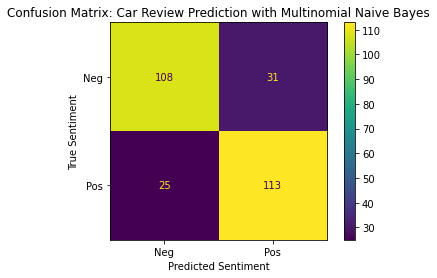

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred))

conf_mat = confusion_matrix(y_true, y_pred, labels=clf.classes_)
disp_obj = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Neg','Pos'])

disp_obj.plot()

disp_obj.ax_.set(title='Confusion Matrix: Car Review Prediction with Multinomial Naive Bayes',
               xlabel='Predicted Sentiment' ,
                ylabel='True Sentiment')

plt.show()

Observations about the Multinomial Naive Bayes Machine Learning Model prediction capabilities
- Accuracy: this model is capable of predicting the right Sentiment 80% of the total observations (sum of the confusion matrix diagonal values, divided by all values).
- Confusion Matrix: clearly shows that the diagonal take most of the values, hence high accuracy. It also shows that the model is a bit better in predicting 'Pos' Sentiment, and also a little bit prone to have higher False Positive than False Negative. This is obviously not auspicable, since this would produce good predicted reviews where instead the reviews were bad.
```
    - True Negative = 108
    - True Positive = 113
    - False Negative (Type II error) = 25
    - False Positive (Type I error) = 31
```
All this is also summarised by the precision and recall results <br>

Looking at F1-score, it is very similar to the accuracy, this is beacuse the data in test are balanced, around same number of 'Pos' vs. 'Neg' samples.

Now, let's have a look at how the model performs on seen data, so training data, the very same data that have been used to train the model.

### Task 2 (50%): Improved solution
Identifying a better approach suitable for this specific task of binary sentiment classification of text-based reviews.<br>
According to C. Manning (2009), stemming has the main limitation that it returns a stem that migth or might not be representating a meaningful word, whereas ***lemmatization*** can help avoiding this issue, since it always returns meaningful words.<br>
According to N. S. Joshi (2014), SVM has outperformed other classifiers such as Naïve Bayes for text classification.<br>
Let's train a machine learning model based on ***Support Vector Classifier (SVC)***.<br>
Note that this is also suggested by the scikit learn diagram https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

First, let's pre-preprocess the text, in particular applying spelling correction, cleaning of double spaces and finally lemmatizing (note that lemmatizing takes time to be run, wound 10min on normal laptop).

In [14]:
import re
from spellchecker import SpellChecker
spell = SpellChecker()


def spell_correct(text):
    """
    Correcting the spelling of each word within the text
    """
    spell_list = []
    for sentence in text:
        spell_sentence = []
        for word in sentence.split():
            spell_sentence.append(spell.correction(word))
        spell_list.append(' '.join(spell_sentence))
        
    return spell_list
    
    
def delete_double_space(text):
    """
    Substituting double space with single space
    """
    for i in range(len(text)):
        text[i] = re.sub(' +', ' ', text[i])
    return text


import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()


def lemmatizing(text):
    """
    Converting a word to its base form, while considering the context it converts the word to 
    its meaningful base form.
    """
    for row in range(len(text)):
        sentence = word_tokenize(text[row])
        sentence = [lemmatizer.lemmatize(word.lower()) for word in sentence if word not in set(stopwords.words('english'))]
        text[row]=' '.join(sentence)
    return text


x_train_list = df_train['Review'].tolist()
x_test_list = df_test['Review'].tolist()

# applying spelling correction
x_train_list = spell_correct(x_train_list) 
x_test_list = spell_correct(x_test_list)
# applying double space deletion
x_train_list = delete_double_space(x_train_list) 
x_test_list = delete_double_space(x_test_list)
# applying lemmatization
x_train_list = lemmatizing(x_train_list)
x_test_list = lemmatizing(x_test_list)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\damat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Here using the Tf-idf method which stands for term frequency-inverse document frequency. This will combine the frequency of a word in a specific sample with the frequency of that word within the entire document.

In [15]:
# TfidfVectorizer should automatically vectorize text data. The resulting features are necessary structure for ML
from sklearn.feature_extraction.text import TfidfVectorizer

# using min_df=3 to ignore features that appear in less than 3 samples
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=0)

X = tfidfvectorizer.fit_transform(x_train_list)
train_bow_arr = X.toarray()

# getting the features names for the training dataset
train_wordset_arr = tfidfvectorizer.get_feature_names()

X = tfidfvectorizer.fit_transform(x_test_list)
test_bow_arr = X.toarray()
# getting the features names for the testing dataset
test_wordset_arr = tfidfvectorizer.get_feature_names()


Second, let's deploy Support Vector Vachine Vlassifier with grid search method to optimise the model hyperparameters. <br>

User:
- please choose `already_optimised = 1` if you prefer to use the SVM best hyperparameters (previously calculated)
- please choose `already_optimised = 0` if you prefer to run the grid search to determine the best hyperparameters (it requires few minutes to complete) <br>

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\damat\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.7s


C:\Users\damat\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ........................C=1, gamma=1, kernel=linear; total time=   4.3s


C:\Users\damat\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.9s


C:\Users\damat\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.4s


C:\Users\damat\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.2s


C:\Users\damat\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'C': 1, 'gamma': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       139
         1.0       0.81      0.81      0.81       138

    accuracy                           0.81       277
   macro avg       0.81      0.81      0.81       277
weighted avg       0.81      0.81      0.81       277



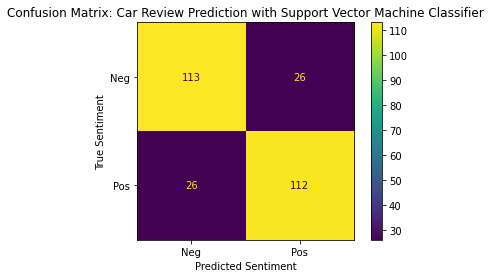

In [16]:
already_optimised = 1

# creating dictionaries to map word to index
train_word_to_idx = {}
for idx, word in enumerate(train_wordset_arr):
    # Set the mapping indexes.
    train_word_to_idx[word] = idx
    
test_word_to_idx = {}
for idx, word in enumerate(test_wordset_arr):
    # Set the mapping indexes.
    test_word_to_idx[word] = idx

# fitting the test bag of words into the features vectorization structure obtained with the training bag of words
test_bow_compatib_arr = 0 * train_bow_arr[0: len(test_bow_arr), :]
test_wordset_compatib_arr = train_wordset_arr
for w_train in train_wordset_arr:
    for w_test in test_wordset_arr:
        if w_train == w_test:
            test_bow_compatib_arr[:, train_word_to_idx[w_train]] = test_bow_arr[:, test_word_to_idx[w_test]]
            

from sklearn.svm import SVC
# machine learning model training phase
# feature matrix
X = train_bow_arr
# target label vector
y = train_target_encode
# fitting the machine learning model
clf = SVC()

# using gridsearch to find the best SVM model hyperparameters
from sklearn.model_selection import GridSearchCV

# selecting if o use already optimised hyperparameters or if to run the grid search
if already_optimised == 1:
    param_grid = {'C': [1], 'gamma': [1], 'kernel': ['linear']}
else:
    param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}


grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)

grid.fit(X, y)

print(grid.best_params_)
# machine learning model prediction phase
y_pred = grid.predict(test_bow_compatib_arr)
y_true = np.ravel(test_target_encode)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred))

conf_mat = confusion_matrix(y_true, y_pred, labels=grid.classes_)
disp_obj = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Neg','Pos'])

disp_obj.plot()

disp_obj.ax_.set(title='Confusion Matrix: Car Review Prediction with Support Vector Machine Classifier',
               xlabel='Predicted Sentiment' ,
                ylabel='True Sentiment')

plt.show()

According to Uiterkamp (2019), N-grams are able to take some context into account when evaluating classes, specifically n words of context. However, this requires an extra filtering step to counter, such as only allowing bigrams that occur at least N amount of times in the training dataset to be added to the vocabulary. Additionally, the probability of encountering the bigrams in new data is smaller than encountering unigrams, which means a larger vocabulary is required to capture a decent number of bigrams in a new text. These problems end up increasing tremendously the size of the vocabulary as n in the n-grams increases.<br>
Here following a bi-grams (N-grams with N=2). Here using the Tf-idf method which stands for term frequency-inverse document frequency. This will combine the frequency of a word in a specific sample with the frequency of that word within the entire document.

In conclusion, the use of lemmatization and SVM with optimised hyperparameters have improved the overall ML model accuracy with test data but only marginally, around 1%.<br>
According to P. Barba (2019), 'When evaluating the sentiment (positive, negative, neutral) of a given text document, research shows that human analysts tend to agree around 80-85% of the time'. This implies that, with a text made of unstructured reviews like the one in input, we might have potentalially hit a limit around 81%, and so we could only improve it slightly with a very high cost in implementation complexity.

### Reference List
- Neha S. Joshi , Suhasini A. Itkat., 2014, *A Survey on Feature Level Sentiment Analysis.* https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.644.1418&rep=rep1&type=pdf
- Wikipedia, Wikimedia Foundation, *Naive Bayes classifier*, 4 March 2022, https://en.wikipedia.org/wiki/Naive_Bayes_classifier
- Luc Schoot Uiterkamp, August 2019, *Improving text representations for NLP from bags of words to strings of words*, http://essay.utwente.nl/79245/1/Schoot%20Uiterkamp_MA_BMS.pdf
- Christopher D. Manning, 2009, *An Introduction to Information Retrieval*, https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf
- Paul Barba, 2019, *Sentiment Accuracy: Explaining the Baseline and How to Test It*, https://www.lexalytics.com/lexablog/sentiment-accuracy-baseline-testing